# NHS Employment Gap Analysis
Analysis of employment rates and gaps between general population and people with long-term conditions in England, using ONS Labour Force Survey data (2006-2018). The dataset is sourced from the NHS Outcomes Framework Indicator 2.2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

data = pd.read_csv("data/NHSOF_2.2_I00707_D.csv")

<h2 id="Initial-Data-Load">Initial Data Load</h2>

Loading the NHS Outcomes Framework Indicator 2.2 dataset from CSV file


In [2]:
print("Data Columns: ", data.columns.to_list())
print(f"Dataset has: {data.shape[0]} rows")
print("Data overview:")
data.head()

Data Columns:  ['Year', 'Quarter', 'Period of coverage', 'Person level weight used', 'Breakdown', 'Level', 'Employment rate of people with long-term conditions', 'Employment rate of population ', 'Indicator value', 'Long-term condition numerator', 'Long-term condition denominator', 'Population numerator', 'Population denominator']
Dataset has: 11999 rows
Data overview:


,Year,Quarter,Period of coverage,Person level weight used,Breakdown,Level,Employment rate of people with long-term conditions,Employment rate of population,Indicator value,Long-term condition numerator,Long-term condition denominator,Population numerator,Population denominator
0,2019,3,01/07/2019 to 30/09/2019,2018 person level weights,England,England,65.6,76.6,10.9,7222500,11002600,26662200,34827200
1,2019,2,01/04/2019 to 30/06/2019,2018 person level weights,England,England,65.3,76.2,10.9,7023900,10759300,26513500,34803800
2,2019b,1,01/01/2019 to 31/03/2019,2018 person level weights,England,England,65,76.2,11.2,6926800,10651800,26512700,34783500
3,2018,4,01/10/2018 to 31/12/2018,2017 person level weights,England,England,64.8,76.2,11.4,6941300,10712900,26499400,34763500
4,2018,3,01/07/2018 to 30/09/2018,2017 person level weights,England,England,64.5,76,11.5,6940100,10755500,26442000,34785200


<h2 id="Data Cleaning">Data Cleaning</h2>

1. Handle missing values (marked with "*")
2. Convert data types for analysis:
   - Years to integers
   - Employment rates to floats
   - Population counts to integers
3. Fix column naming inconsistencies

In [3]:
# Convert suppressed data points (marked with "*") to NaN
df = data.replace({"*": np.nan})

# Analyze missing data distribution across columns
print("Check for missing values:")
print(df.isna().sum())

Check for missing values:
Year                                                    0
Quarter                                                 0
Period of coverage                                      0
Person level weight used                                0
Breakdown                                               0
Level                                                   0
Employment rate of people with long-term conditions    66
Employment rate of population                          32
Indicator value                                        74
Long-term condition numerator                          78
Long-term condition denominator                        36
Population numerator                                   32
Population denominator                                  4
dtype: int64


In [4]:
# Remove suppressed data points (no imputation due to intentional suppression)
df = df.dropna()
print(f"After removing NaN values, Shape: {df.shape}")

After removing NaN values, Shape: (11913, 13)


In [5]:
# Clean year values by removing revision markers ('b' suffix) 
# Note: The 'b' suffix indicates revised data points in the ONS dataset
df['Year'] = df['Year'].replace({ "2019b": "2019", 
                                    "2017b": "2017", 
                                    "2016b": "2016", 
                                    "2014b": "2014", 
                                    "2011b": "2011", })

# Convert columns to appropriate data types
df['Year'] = df['Year'].astype(int)
df['Employment rate of people with long-term conditions'] = df['Employment rate of people with long-term conditions'].astype(float)
df['Employment rate of population '] = df['Employment rate of population '].astype(float)
df['Indicator value'] = df['Indicator value'].astype(float)
df['Long-term condition numerator'] = df['Long-term condition numerator'].astype(int)
df['Long-term condition denominator'] = df['Long-term condition denominator'].astype(int)
df['Population numerator'] = df['Population numerator'].astype(int)
df['Population denominator'] = df['Population denominator'].astype(int)

# Fix inconsistent column naming (remove trailing space)
df = df.rename(columns={'Employment rate of population ': 'Employment rate of population'})

## Time Series Analysis
Creating visualizations and statistics for:
1. Q4 trends for England
2. Breakdown analysis by:
   - Gender
   - Ethnicity
   - Region
   - Religion
   - NS-SEC category

In [6]:
def quarter_year_to_datetime(year, quarter):
  """
  Converts year and quarter to datetime objects representing the start of the quarter.
  
  Parameters:
  - year: The year (e.g., 2019)
  - quarter: The quarter (1-4)
  
  Returns:
  - datetime object for the first day of the quarter
  Example: 2019 Q2 -> 2019-04-01
  """
  return pd.to_datetime(f'{year}-{(quarter - 1) * 3 + 1}-01')

# Add datetime column for time series analysis
df['date'] = df.apply(lambda x: quarter_year_to_datetime(x['Year'], x['Quarter']), axis=1)

In [7]:
# Organize columns by category
# Note: Person level weight used is a statistical adjustment factor applied to survey responses
# to ensure the sample represents the wider population accurately
cols = ['date', 'Year', 'Quarter', 'Period of coverage', 'Person level weight used',
       'Breakdown', 'Level','Employment rate of people with long-term conditions',
       'Employment rate of population', 'Indicator value',
       'Long-term condition numerator', 'Long-term condition denominator',
       'Population numerator', 'Population denominator']
df = df[cols]

Focus on Q4 data for each year:
1. Reduces seasonal variations for more stable year-over-year comparisons
2. Q4 data typically represents the most mature picture of employment trends for each year
3. Simplifies visualization and analysis by avoiding seasonal fluctuations
4. Aligns with common practice in annual employment reporting
5. Provides cleaner trend analysis by using consistent time points

In [8]:
q4_df = df[df['Quarter'] == 4].copy()

## Analysis of Q4 Population and Long-term Condition Numbers - England

The figure shows several key trends in England's population and long-term condition numbers from 2006 to 2018:

- Total population (orange bars) demonstrates steady growth over the 12-year period
- Long-term condition numbers (blue bars) have remained relatively stable
- By 2018, approximately 25-30% of the population had long-term conditions
- The stable proportion of people with long-term conditions despite population growth suggests:
  - Effective healthcare interventions
  - Consistent diagnostic criteria
  - Or a balance between new cases and recoveries/exits

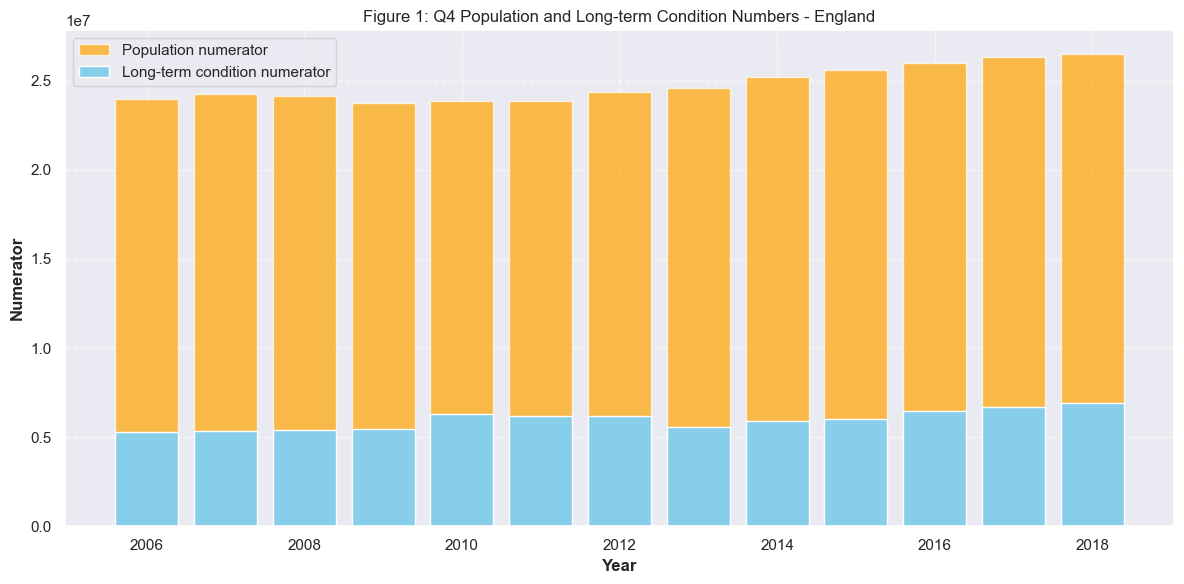

In [9]:
# Extract England-specific Q4 data
england_q4 = q4_df[q4_df['Breakdown'] == 'England']

# Initialize figure counter
fig_counter = 1

# Visualize population counts
plt.figure(figsize=(12, 6))
plt.bar(england_q4['Year'], england_q4['Population numerator'], 
        color='orange', alpha=0.7, label='Population numerator')
plt.bar(england_q4['Year'], england_q4['Long-term condition numerator'], 
        color='skyblue', label='Long-term condition numerator')
plt.ylabel('Numerator', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
title = f'Figure {fig_counter}: Q4 Population and Long-term Condition Numbers - England'
plt.title(title)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
plt.show()
fig_counter += 1

## Analysis of Q4 Employment Rates and Gap - England

The employment rates and gap analysis reveals important patterns:

- The employment rate for the general population has shown an upward trend
- People with long-term conditions consistently show lower employment rates
- The employment gap (shaded area) has remained persistent over time
- There was a slight narrowing of the gap in recent years, suggesting:
  - Improved workplace accommodations
  - Better support systems for people with long-term conditions
  - More inclusive employment practices
- However, a significant employment disparity still exists, indicating more work is needed

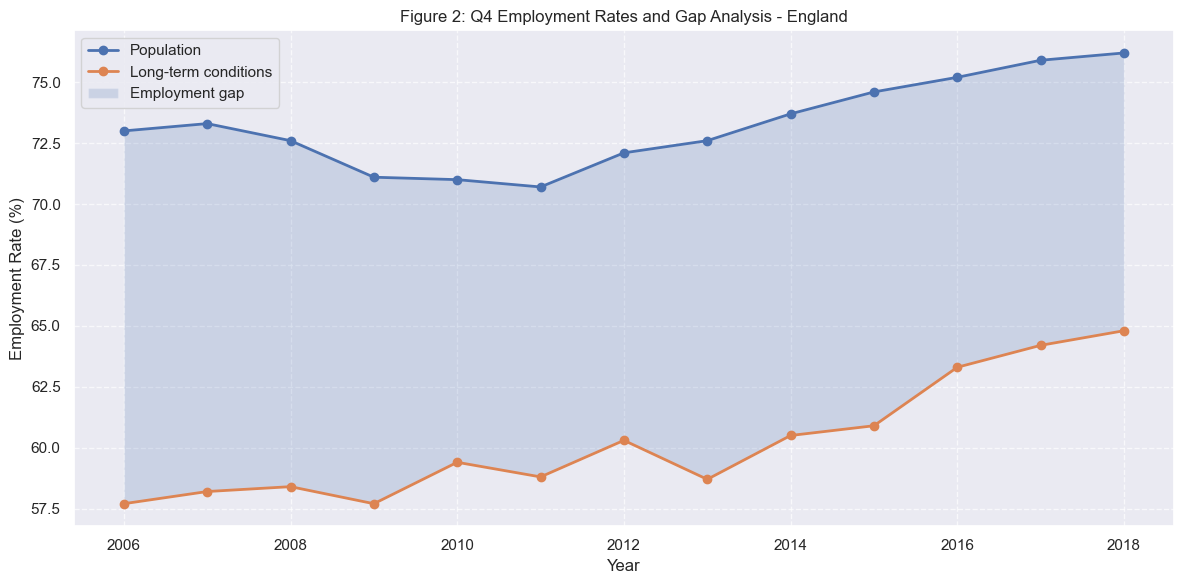

In [10]:
# Compare employment rates and visualize gap
plt.figure(figsize=(12, 6))
plt.plot(england_q4['Year'], england_q4['Employment rate of population'], 
         marker='o', label='Population', linewidth=2)
plt.plot(england_q4['Year'], england_q4['Employment rate of people with long-term conditions'], 
         marker='o', label='Long-term conditions', linewidth=2)
plt.fill_between(england_q4['Year'], 
                 england_q4['Employment rate of population'],
                 england_q4['Employment rate of people with long-term conditions'],
                 alpha=0.2, label='Employment gap')
title = f'Figure {fig_counter}: Q4 Employment Rates and Gap Analysis - England'
plt.title(title)
plt.xlabel('Year')
plt.ylabel('Employment Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
plt.show()
fig_counter += 1

In [11]:
# Create reusable plotting function for demographic breakdowns
def plot_q4_breakdown(breakdown, metric='Indicator value', title_suffix='Employment Gap', counter=1):
    """
    Generate time series plots for demographic breakdowns.
    
    Returns:
    - Updated figure counter
    """
    breakdown_q4 = q4_df[q4_df['Breakdown'] == breakdown]
    
    # Get total population for each level and select top 10 by population size
    level_populations = breakdown_q4.groupby('Level')['Population denominator'].sum().sort_values(ascending=False)
    levels_to_plot = level_populations.index.tolist()
    if len(levels_to_plot) > 10:
        levels_to_plot = levels_to_plot[:10]
    
    plt.figure(figsize=(12, 6))
    for level in levels_to_plot:
        level_data = breakdown_q4[breakdown_q4['Level'] == level]
        plt.plot(level_data['Year'], level_data[metric], 
                marker='o', label=level, linewidth=2)
    
    title = f'Figure {counter}: {breakdown} - Q4 {title_suffix}'
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(metric.replace('_', ' '))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
    plt.show()
    return counter + 1

## Gender Analysis

The gender-based analysis reveals several notable patterns:

In [12]:
# Analyze Q4 patterns for key breakdowns
# Gender analysis
breakdown = 'Gender'

### Employment Gap (Figure 3)
- Women with long-term conditions face a larger employment gap compared to men
- The gap has been persistent over time for both genders
- Recent years show slight improvement in reducing the gap for both groups

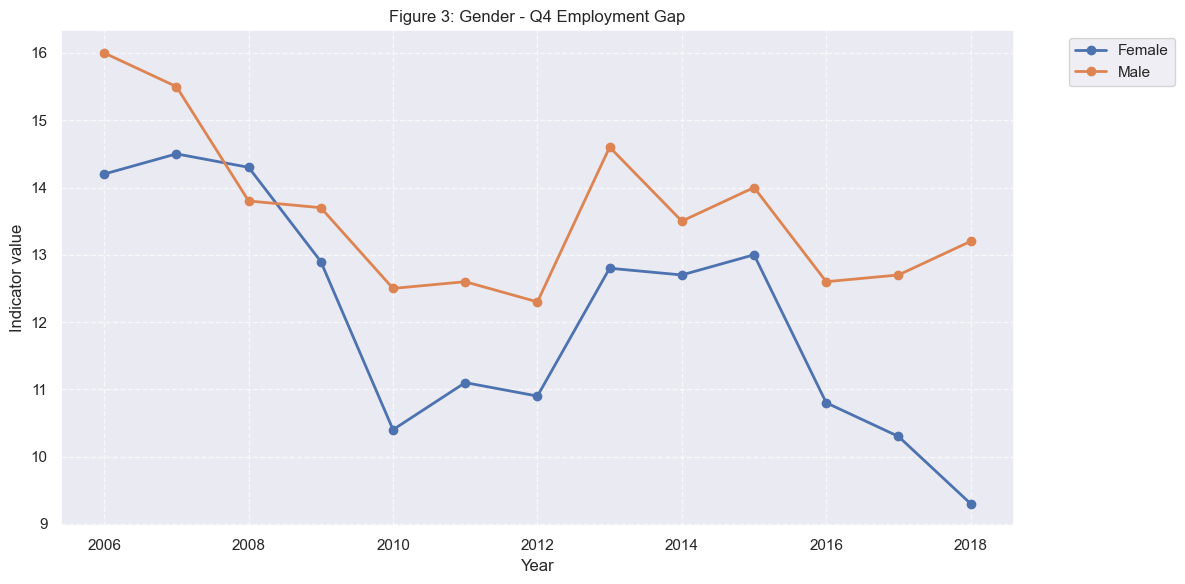

In [13]:
fig_counter = plot_q4_breakdown(breakdown, 'Indicator value', 'Employment Gap', fig_counter)

### Long-term Conditions Employment Rate (Figure 4)
- Men with long-term conditions consistently show higher employment rates
- Both genders show gradual improvement in employment rates over time
- The employment rate difference between genders has remained relatively stable

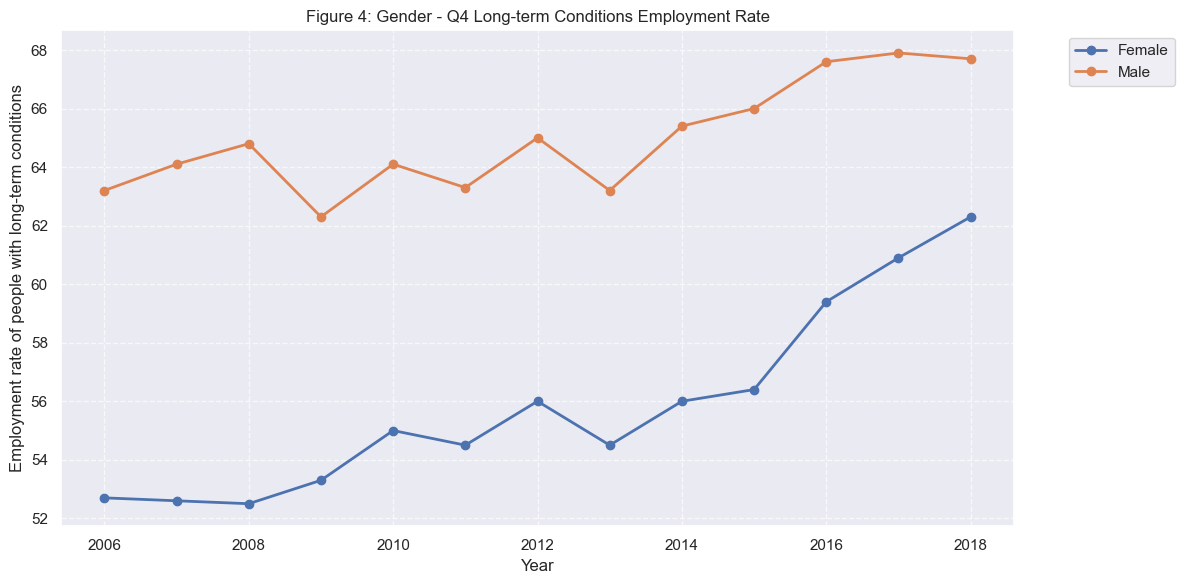

In [14]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of people with long-term conditions', 
                     'Long-term Conditions Employment Rate', fig_counter)

### Population Employment Rate (Figure 5)
- Overall employment rates are higher for men across all years
- Both genders show upward trends in employment rates
- The gender employment gap in the general population mirrors patterns seen in the long-term conditions group

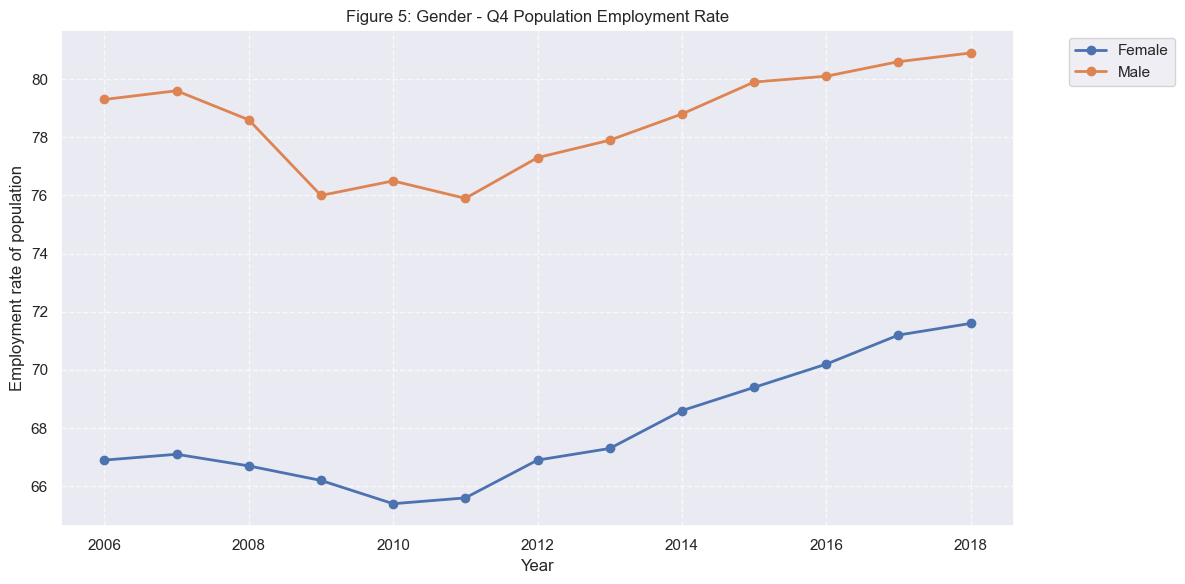

In [15]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of population', 
                     'Population Employment Rate', fig_counter)

## Ethnicity Analysis

The ethnicity-based analysis shows significant variations in employment patterns:

In [16]:
# Ethnicity analysis
breakdown = 'Ethnicity'

### Employment Gap (Figure 6)
- Employment gaps vary considerably across ethnic groups
- Some ethnic minorities show larger employment gaps than the national average
- The gaps have remained relatively stable over time, suggesting persistent structural challenges

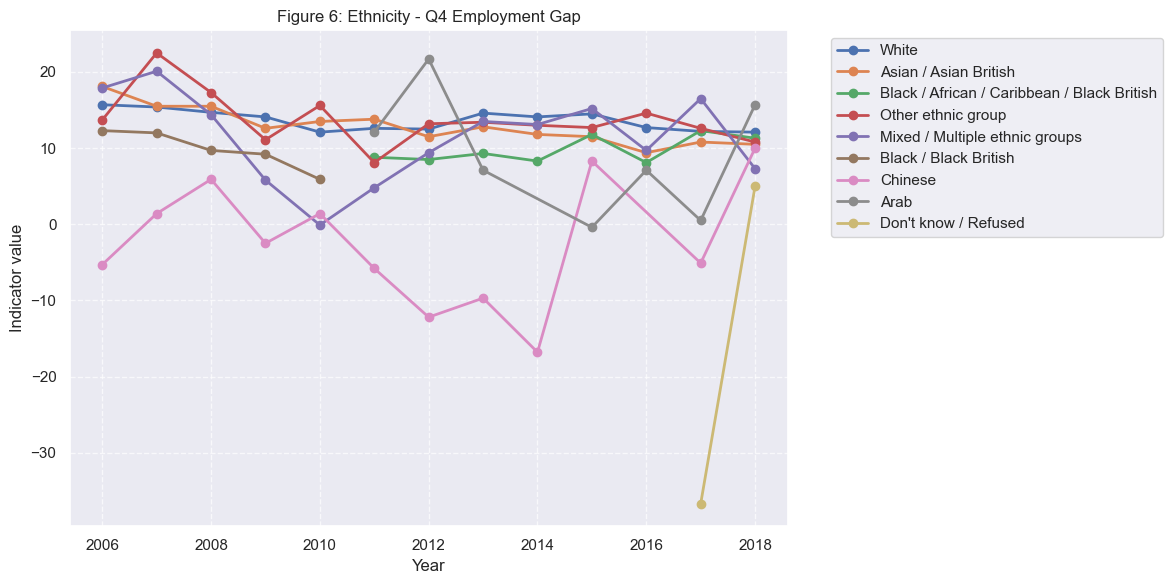

In [17]:
fig_counter = plot_q4_breakdown(breakdown, 'Indicator value', 'Employment Gap', fig_counter)

### Long-term Conditions Employment Rate (Figure 7)
- Employment rates for people with long-term conditions vary significantly by ethnicity
- Most ethnic groups show gradual improvements over time
- Some ethnic groups consistently show lower employment rates, indicating potential barriers

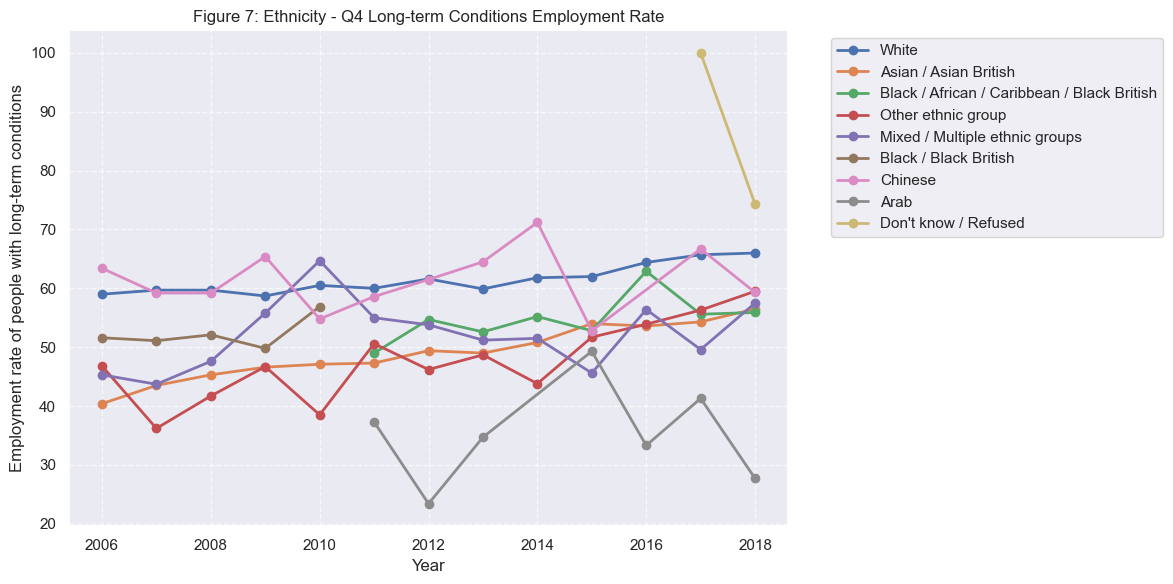

In [18]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of people with long-term conditions', 
                     'Long-term Conditions Employment Rate', fig_counter)

### Population Employment Rate (Figure 8)
- General population employment rates differ across ethnic groups
- Most groups show improvement in recent years
- Employment rate disparities between ethnic groups persist despite overall improvements

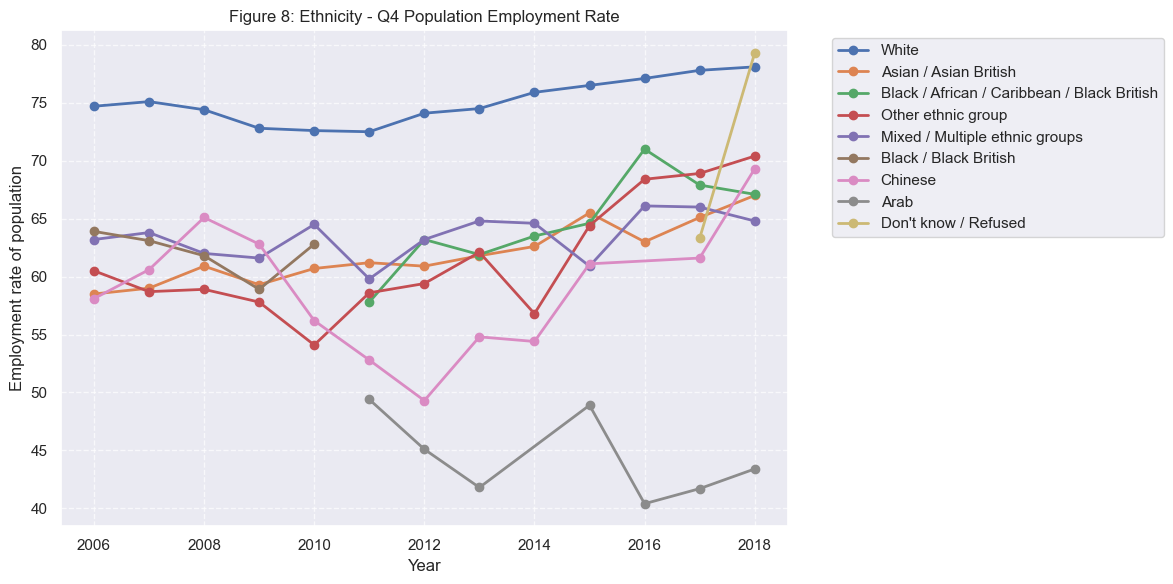

In [19]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of population', 
                     'Population Employment Rate', fig_counter)

## Regional Analysis

The regional analysis highlights geographic variations in employment outcomes:

In [20]:
# Region analysis
breakdown = 'Region'

### Employment Gap (Figure 9)
- Significant regional disparities exist in employment gaps
- London and some northern regions show larger employment gaps
- Regional variations have persisted over time, suggesting localized challenges

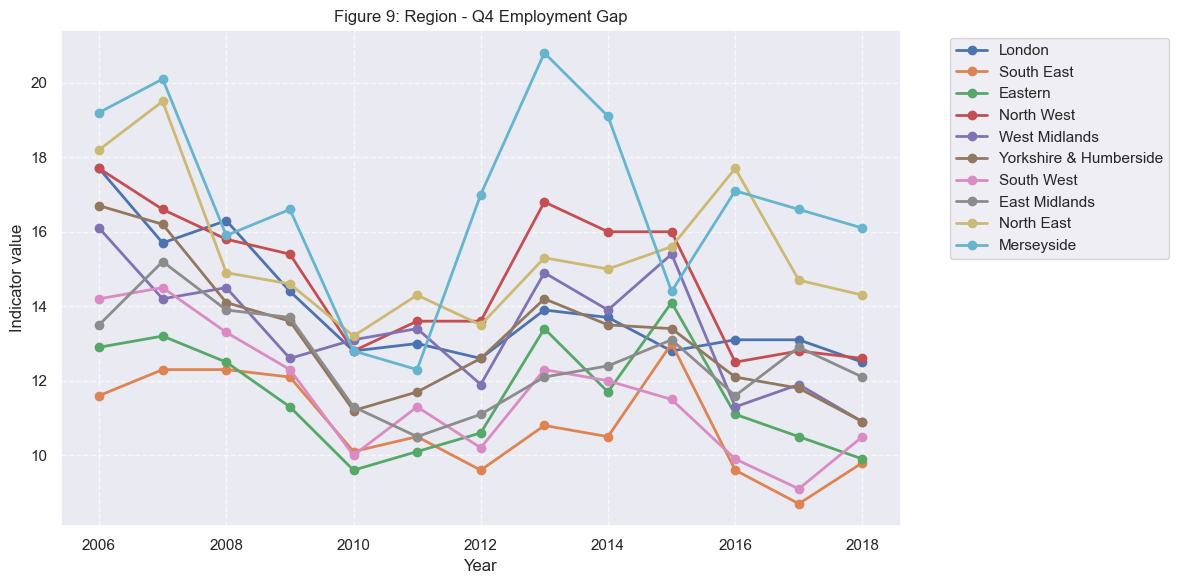

In [21]:
fig_counter = plot_q4_breakdown(breakdown, 'Indicator value', 'Employment Gap', fig_counter)

### Long-term Conditions Employment Rate (Figure 10)
- Employment rates for people with long-term conditions vary by region
- Southern regions generally show higher employment rates
- All regions show some improvement over time, but at different rates

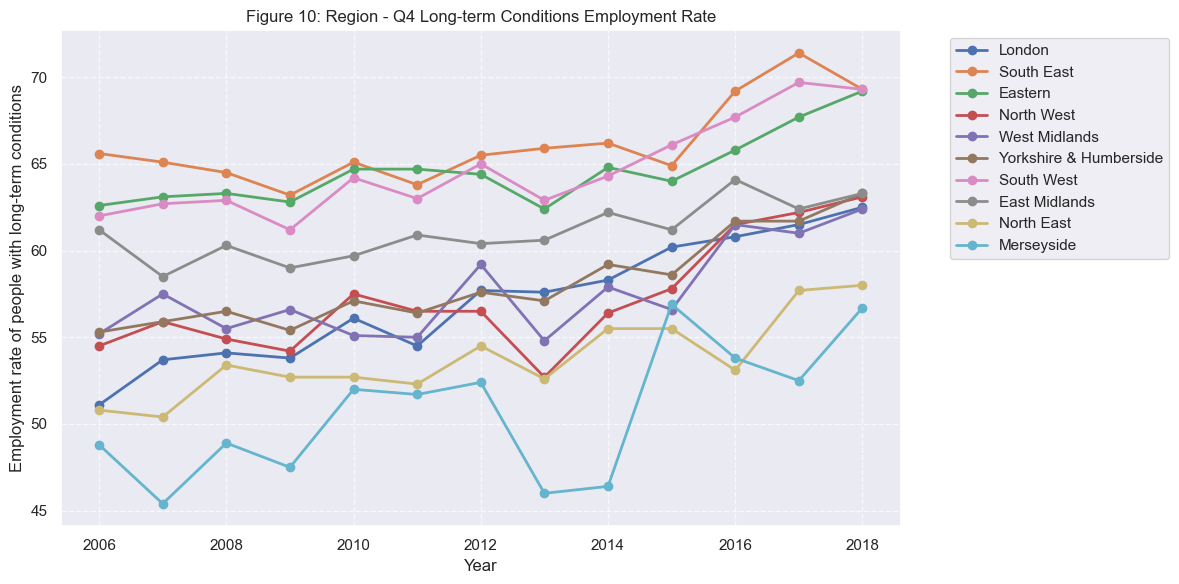

In [22]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of people with long-term conditions', 
                     'Long-term Conditions Employment Rate', fig_counter)

### Population Employment Rate (Figure 11)
- Overall employment rates show clear regional patterns
- London shows unique employment patterns compared to other regions
- Regional economic differences are reflected in employment outcomes


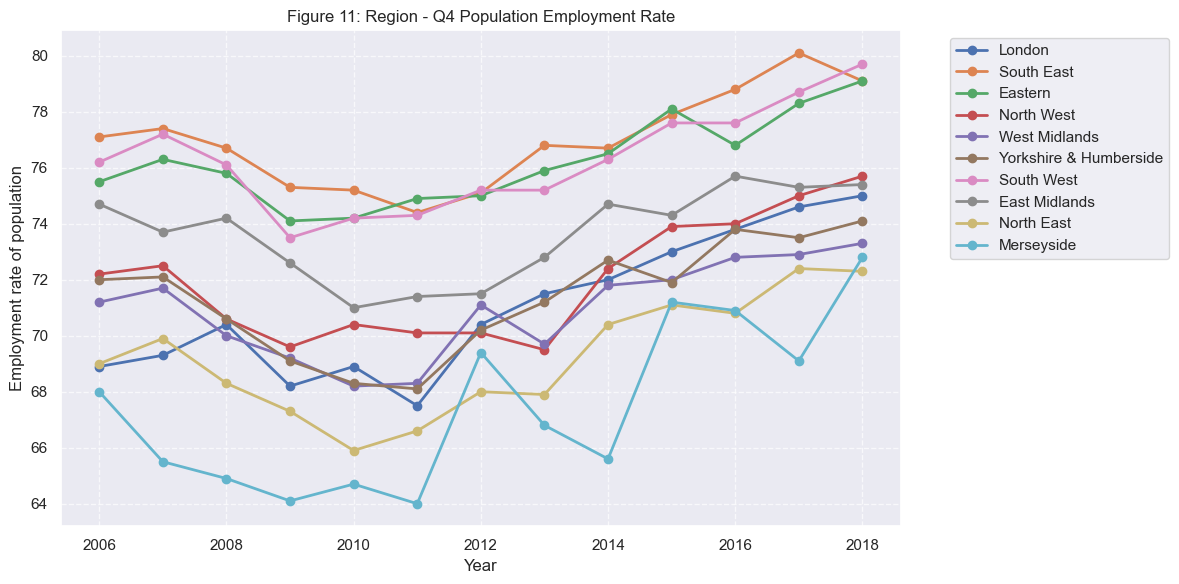

In [23]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of population', 
                     'Population Employment Rate', fig_counter)

## Religion Analysis

Analysis of employment patterns across religious groups reveals distinct trends:

In [24]:
# Religion analysis
breakdown = 'Religion'

### Employment Gap (Figure 12)
- Employment gaps vary significantly across religious groups
- Some religious minorities experience larger employment gaps
- The gaps show some fluctuation over time but remain persistent

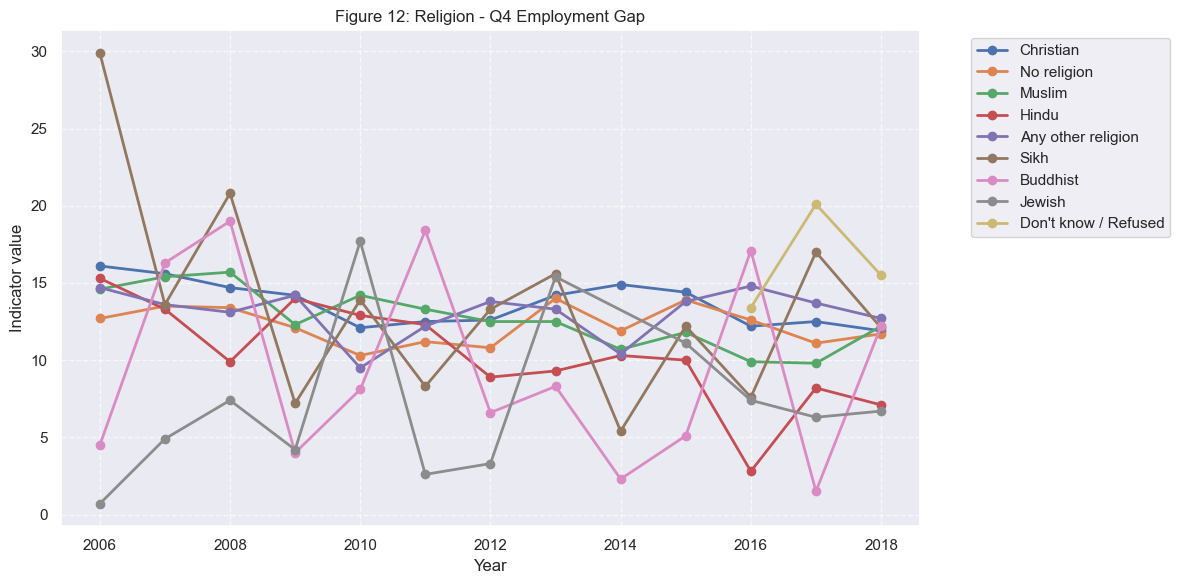

In [25]:
fig_counter = plot_q4_breakdown(breakdown, 'Indicator value', 'Employment Gap', fig_counter)

### Long-term Conditions Employment Rate (Figure 13)
- Employment rates for people with long-term conditions differ by religious group
- Most groups show modest improvements over the study period
- Some religious groups consistently face greater employment challenges

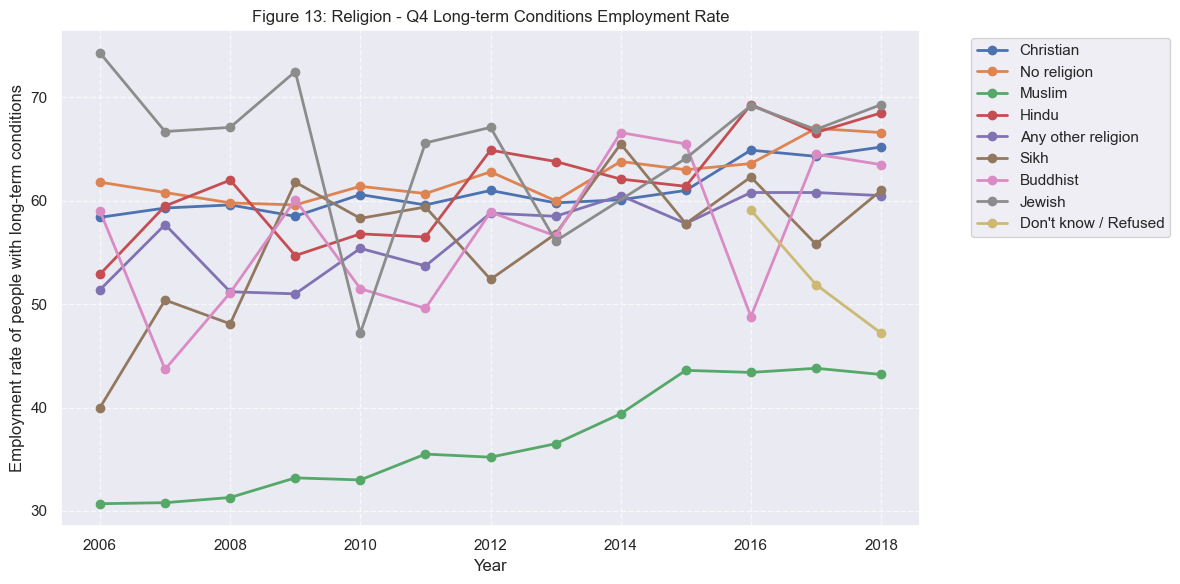

In [26]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of people with long-term conditions', 
                     'Long-term Conditions Employment Rate', fig_counter)

### Population Employment Rate (Figure 14)
- General population employment rates vary across religious groups
- Different religious groups show varying patterns of recovery following the 2008-2009 financial crisis
- Employment rate variations suggest potential cultural and structural factors in workforce participation

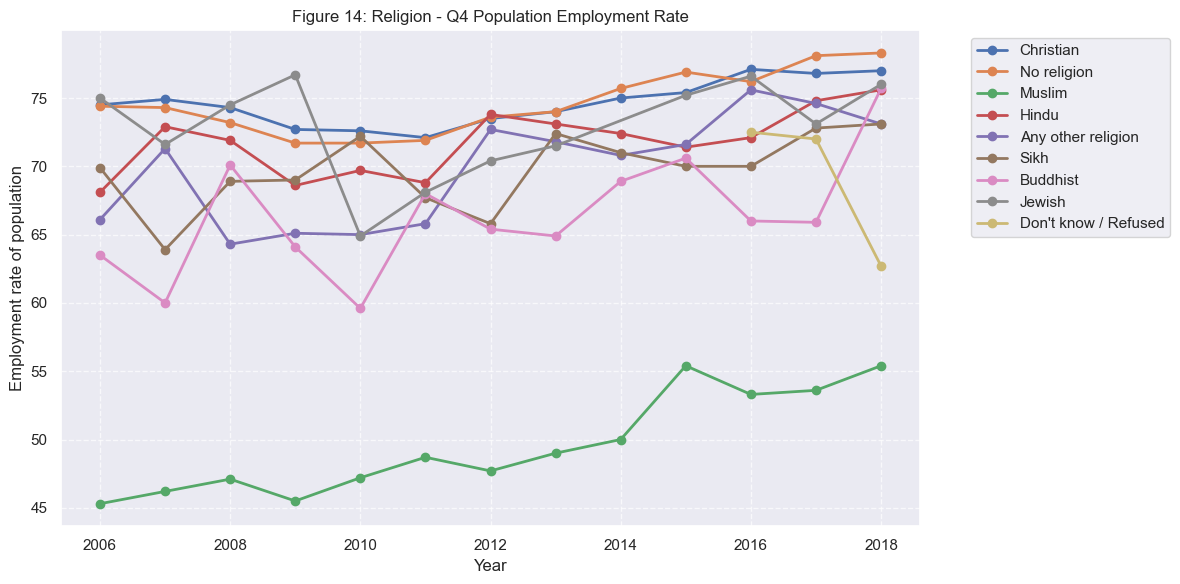

In [27]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of population', 
                     'Population Employment Rate', fig_counter)

## NS-SEC Category Analysis

Analysis of employment patterns across socio-economic classifications:

In [28]:
# NS-SEC category analysis
breakdown = 'NS-SEC category'

### Employment Gap (Figure 15)
- Employment gaps vary substantially across NS-SEC categories
- Higher professional categories generally show smaller employment gaps
- Lower technical and routine categories show larger employment disparities

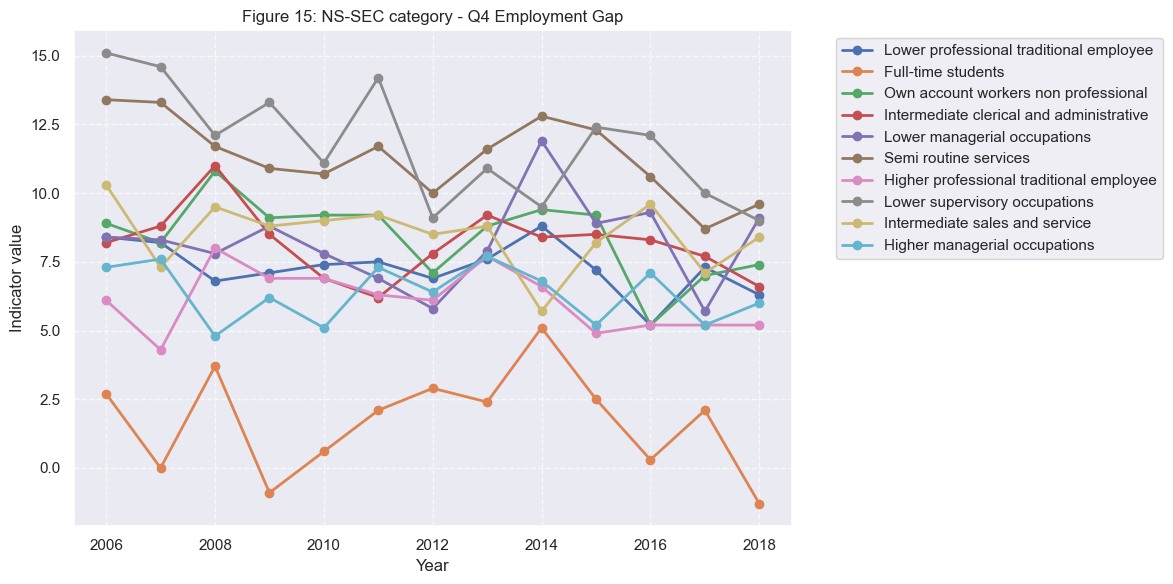

In [29]:
fig_counter = plot_q4_breakdown(breakdown, 'Indicator value', 'Employment Gap', fig_counter)

### Long-term Conditions Employment Rate (Figure 16)
- Employment rates for people with long-term conditions differ by socio-economic class
- Higher professional categories maintain better employment outcomes
- Technical and routine workers show more vulnerability to employment challenges

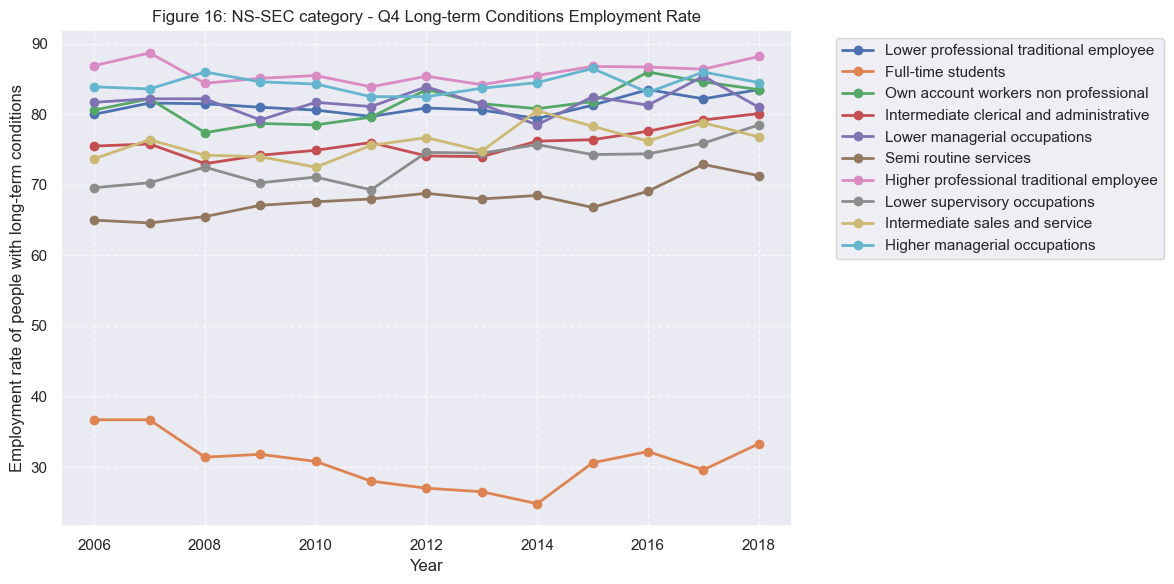

In [30]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of people with long-term conditions', 
                     'Long-term Conditions Employment Rate', fig_counter)

### Population Employment Rate (Figure 17)
- Clear stratification in employment rates across socio-economic groups
- Professional categories show consistently higher employment rates
- Economic events impact different NS-SEC categories to varying degrees

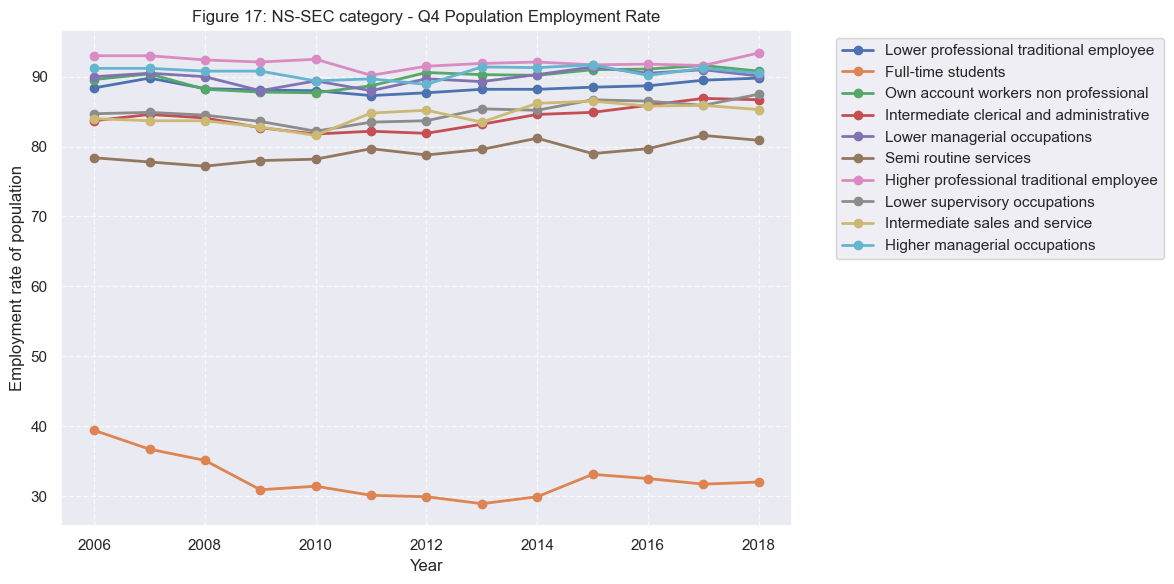

In [31]:
fig_counter = plot_q4_breakdown(breakdown, 'Employment rate of population', 
                     'Population Employment Rate', fig_counter)

## Q4 Summary Statistics Analysis

### Gender Employment Gap Analysis
The employment gap between the general population and those with long-term conditions shows notable gender differences:
- Female workers face a slightly lower employment gap (12.09%) compared to male workers (13.62%)
- Female employment gaps show higher variability (std: 1.72 vs 1.17 for males)
- The range of employment gaps is wider for males (12.3-16.0%) than females (9.3-14.5%)

In [32]:
# Calculate and display summary statistics for the entire period
print("\nQ4 Summary Statistics for Employment Gap by Breakdown:")
# Gender statistics
print("\nGender:")
breakdown_stats = q4_df[q4_df['Breakdown'] == 'Gender'].groupby('Level')['Indicator value'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(breakdown_stats)


Q4 Summary Statistics for Employment Gap by Breakdown:

Gender:
         mean   std   min   max
Level                          
Female  12.09  1.72   9.3  14.5
Male    13.62  1.17  12.3  16.0


### Ethnicity Employment Gap Analysis
Significant variations exist across ethnic groups:
- Chinese workers show a unique negative gap (-2.53%), suggesting higher employment rates for those with long-term conditions
- White and Other ethnic groups show similar gaps (13.64% and 13.74% respectively)
- Black/African/Caribbean groups consistently show lower gaps (~9.8%)
- High standard deviations in some groups (e.g., Chinese: 8.26, Arab: 8.00) indicate significant temporal variations

In [33]:
# Ethnicity statistics
print("\nEthnicity:")
breakdown_stats = q4_df[q4_df['Breakdown'] == 'Ethnicity'].groupby('Level')['Indicator value'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(breakdown_stats)


Ethnicity:
                                              mean    std   min   max
Level                                                                
Arab                                          9.11   8.00  -0.4  21.7
Asian / Asian British                        12.87   2.40   9.4  18.1
Black / African / Caribbean / Black British   9.80   1.71   8.1  12.3
Black / Black British                         9.82   2.58   5.9  12.3
Chinese                                      -2.53   8.26 -16.8  10.0
Don't know / Refused                        -15.85  29.49 -36.7   5.0
Mixed / Multiple ethnic groups               11.35   5.81  -0.1  20.1
Other ethnic group                           13.74   3.47   8.1  22.5
White                                        13.64   1.31  12.1  15.7


### Regional Employment Gap Analysis
Clear regional patterns emerge in employment gaps:
- Merseyside shows the highest average gap (16.77%) with significant variability (std: 2.61)
- North East follows with a 15.45% gap
- South East shows the lowest gap (10.84%) with relatively low variability (std: 1.31)
- London's gap (13.97%) sits above the national average despite its economic prominence

In [34]:
# Region statistics
print("\nRegion:")
breakdown_stats = q4_df[q4_df['Breakdown'] == 'Region'].groupby('Level')['Indicator value'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(breakdown_stats)


Region:
                         mean   std   min   max
Level                                          
East Midlands           12.57  1.31  10.5  15.2
Eastern                 11.61  1.48   9.6  14.1
London                  13.97  1.63  12.5  17.7
Merseyside              16.77  2.61  12.3  20.8
North East              15.45  1.88  13.2  19.5
North West              14.78  1.85  12.5  17.7
South East              10.84  1.31   8.7  13.0
South West              11.62  1.69   9.1  14.5
West Midlands           13.39  1.62  10.9  16.1
Yorkshire & Humberside  13.23  1.79  10.9  16.7


### Religion Employment Gap Analysis
Employment gaps vary notably across religious groups:
- Jewish people show the lowest average gap (7.31%)
- Buddhist communities show moderate gaps (9.49%) but high variability (std: 6.34)
- Christian and Muslim communities show similar gaps (13.68% and 12.68% respectively)
- Sikh communities show high variability in employment gaps (std: 6.52)

In [42]:
# Religion statistics
print("\nReligion:")
breakdown_stats = q4_df[q4_df['Breakdown'] == 'Religion'].groupby('Level')['Indicator value'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(breakdown_stats)

# NS-SEC category statistics
# print("\nNS-SEC category:")
# breakdown_stats = q4_df[q4_df['Breakdown'] == 'NS-SEC category'].groupby('Level')['Indicator value'].agg([
#     'mean', 'std', 'min', 'max'
# ]).round(2)
# print(breakdown_stats)


Religion:
                       mean   std   min   max
Level                                        
Any other religion    13.06  1.57   9.5  14.8
Buddhist               9.49  6.34   1.5  19.0
Christian             13.68  1.44  11.9  16.1
Don't know / Refused  16.33  3.43  13.4  20.1
Hindu                 10.33  3.32   2.8  15.3
Jewish                 7.31  5.10   0.7  17.7
Muslim                12.68  1.92   9.8  15.7
No religion           12.25  1.22  10.3  14.0
Sikh                  13.61  6.52   5.4  29.9


In [36]:
# Specify technical and engineering job categories for focused analysis
selected_categories = [
    'Higher professional new employee',
    'Intermediate engineering',
    'Intermediate technical and auxiliary',
    'Lower professional new employee',
    'Lower technical craft',
    'Lower technical process operative',
    'Routine technical',
    'Semi routine technical'
]

## Technical Sector Focus
Analysis of employment rates in technical and engineering roles across NS-SEC (National Statistics Socio-economic Classification) categories. NS-SEC is the UK's official socio-economic classification, categorizing occupations based on employment relations and conditions.

In [37]:
# Extract technical sector data
tech_eng_data = q4_df[
    (q4_df['Breakdown'] == 'NS-SEC category') & 
    (q4_df['Level'].isin(selected_categories))
]

### Population Employment Rate (Figure 18)
- Higher professional roles show the strongest employment rates
- Clear hierarchy in employment rates across technical roles
- Employment stability varies by technical role level

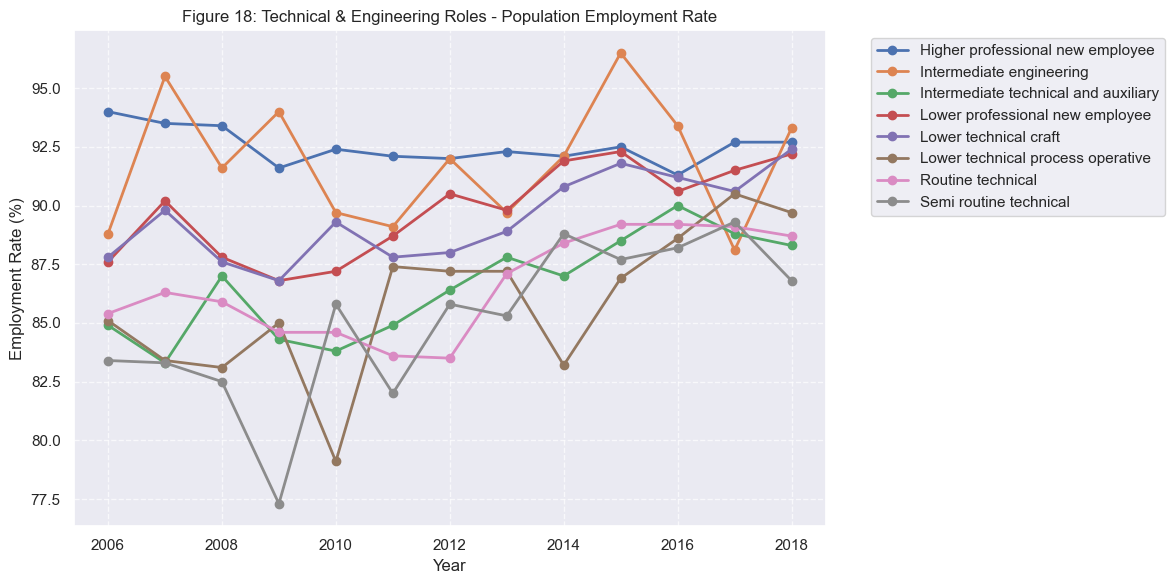

In [38]:
# Plot population employment rate
plt.figure(figsize=(12, 6))
for level in selected_categories:
    level_data = tech_eng_data[tech_eng_data['Level'] == level]
    plt.plot(level_data['Year'], 
            level_data['Employment rate of population'],
            marker='o', label=level, linewidth=2)

title = f'Figure {fig_counter}: Technical & Engineering Roles - Population Employment Rate'
plt.title(title)
plt.xlabel('Year')
plt.ylabel('Employment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
plt.show()
fig_counter += 1

### Long-term Conditions Employment Rate (Figure 19)
- Employment rates for people with long-term conditions vary by technical role
- Higher-level technical positions show better employment outcomes
- The impact of long-term conditions varies across technical categories

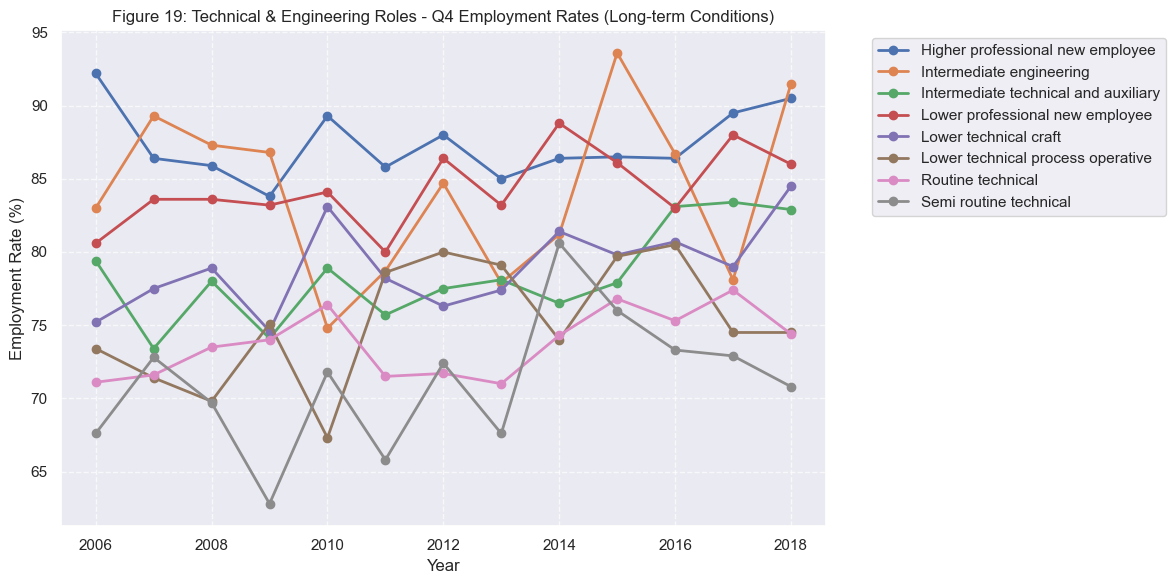

In [39]:
# Visualize employment rates across technical roles
plt.figure(figsize=(12, 6))
for level in selected_categories:
    level_data = tech_eng_data[tech_eng_data['Level'] == level]
    plt.plot(level_data['Year'], 
            level_data['Employment rate of people with long-term conditions'],
            marker='o', label=level, linewidth=2)

title = f'Figure {fig_counter}: Technical & Engineering Roles - Q4 Employment Rates (Long-term Conditions)'
plt.title(title)
plt.xlabel('Year')
plt.ylabel('Employment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
plt.show()
fig_counter += 1

### Employment Gap (Figure 20)
- Employment gaps differ significantly across technical roles
- Higher professional roles generally show smaller gaps (5.16-6.36%)
- Lower technical roles face larger employment disparities
- The pattern suggests a correlation between role complexity and employment accessibility

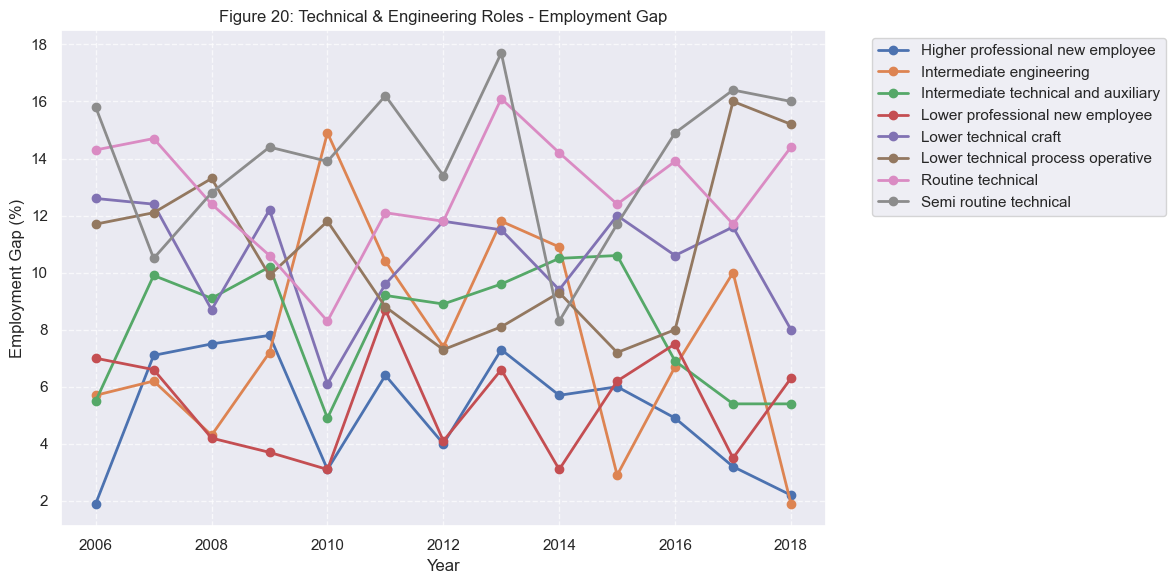

In [40]:
# Plot indicator value (employment gap)
plt.figure(figsize=(12, 6))
for level in selected_categories:
    level_data = tech_eng_data[tech_eng_data['Level'] == level]
    plt.plot(level_data['Year'], 
            level_data['Indicator value'],
            marker='o', label=level, linewidth=2)

title = f'Figure {fig_counter}: Technical & Engineering Roles - Employment Gap'
plt.title(title)
plt.xlabel('Year')
plt.ylabel('Employment Gap (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(f'figures/{title.replace(":", "").replace(" ", "_")}.png')
plt.show()
fig_counter += 1

### Technical & Engineering Roles Analysis
Employment gaps show a clear pattern across technical roles:
- Higher professional roles consistently show smaller gaps (5.16-6.36%)
- Semi-routine technical roles show larger gaps (14.00%)
- Employment rates for those with long-term conditions decrease as role complexity decreases:
  * Higher professional new employee: 87.36% employment rate
  * Semi-routine technical: 71.08% employment rate
- Standard deviations generally increase in lower-skilled roles, indicating less stability

In [44]:
print("\nTechnical & Engineering Roles Summary Statistics:")
tech_eng_data = q4_df[
    (q4_df['Breakdown'] == 'NS-SEC category') & 
    (q4_df['Level'].isin(selected_categories))
]
for category in selected_categories[:3]:
    print(f"\n{category}:")
    category_stats = tech_eng_data[tech_eng_data['Level'] == category].agg({
        'Employment rate of people with long-term conditions': ['mean', 'std', 'min', 'max'],
        'Employment rate of population': ['mean', 'std', 'min', 'max'],
        'Indicator value': ['mean', 'std', 'min', 'max']
    }).round(2)
    print(category_stats)


Technical & Engineering Roles Summary Statistics:

Higher professional new employee:
      Employment rate of people with long-term conditions  \
mean                                              87.36     
std                                                2.39     
min                                               83.80     
max                                               92.20     

      Employment rate of population  Indicator value  
mean                          92.51             5.16  
std                            0.76             2.09  
min                           91.30             1.90  
max                           94.00             7.80  

Intermediate engineering:
      Employment rate of people with long-term conditions  \
mean                                              84.12     
std                                                5.75     
min                                               74.80     
max                                               93.60     



In [45]:
for category in selected_categories[3:6]:
    print(f"\n{category}:")
    category_stats = tech_eng_data[tech_eng_data['Level'] == category].agg({
        'Employment rate of people with long-term conditions': ['mean', 'std', 'min', 'max'],
        'Employment rate of population': ['mean', 'std', 'min', 'max'],
        'Indicator value': ['mean', 'std', 'min', 'max']
    }).round(2)
    print(category_stats)


Lower professional new employee:
      Employment rate of people with long-term conditions  \
mean                                              84.35     
std                                                2.61     
min                                               80.00     
max                                               88.80     

      Employment rate of population  Indicator value  
mean                          89.78             5.43  
std                            1.97             1.88  
min                           86.80             3.10  
max                           92.30             8.70  

Lower technical craft:
      Employment rate of people with long-term conditions  \
mean                                              78.97     
std                                                2.93     
min                                               74.60     
max                                               84.50     

      Employment rate of population  Indicator value  


In [47]:
for category in selected_categories[6:]:
    print(f"\n{category}:")
    category_stats = tech_eng_data[tech_eng_data['Level'] == category].agg({
        'Employment rate of people with long-term conditions': ['mean', 'std', 'min', 'max'],
        'Employment rate of population': ['mean', 'std', 'min', 'max'],
        'Indicator value': ['mean', 'std', 'min', 'max']
    }).round(2)
    print(category_stats)


Routine technical:
      Employment rate of people with long-term conditions  \
mean                                              73.77     
std                                                2.26     
min                                               71.00     
max                                               77.40     

      Employment rate of population  Indicator value  
mean                          86.58            12.84  
std                            2.17             2.05  
min                           83.50             8.30  
max                           89.20            16.10  

Semi routine technical:
      Employment rate of people with long-term conditions  \
mean                                              71.08     
std                                                4.57     
min                                               62.80     
max                                               80.60     

      Employment rate of population  Indicator value  
mean         

# 6. Summary and Key Findings

## Overall Summary
This analysis examines employment patterns in England, focusing on the gap between general population employment rates and those with long-term conditions. The study spans multiple years and considers various demographic factors, revealing persistent employment disparities despite some improvements over time.

## Key Findings

### Population and Long-term Condition Trends
- Total population showed steady growth from 2006 to 2018
- Long-term condition numbers remained relatively stable at 25-30% of population
- Stable proportion suggests effective healthcare interventions or consistent diagnostic criteria

### Employment Gap Analysis
- Persistent employment gap between general population and those with long-term conditions
- Slight narrowing of gap in recent years indicates improving workplace inclusivity
- Employment rates for general population show upward trend
- People with long-term conditions consistently show lower employment rates

### Demographic Insights

#### Gender
- Women with long-term conditions face larger employment gaps
- Men show consistently higher employment rates across both groups
- Recent years show slight improvement in reducing gaps for both genders

#### Ethnicity
- Significant variations across ethnic groups
- Chinese workers show unique negative gap (-2.53%)
- White and Other ethnic groups show similar gaps (~13.7%)
- Black/African/Caribbean groups show lower gaps (~9.8%)

#### Regional Variations
- Merseyside shows highest average gap (16.77%)
- South East shows lowest gap (10.84%)
- London's gap (13.97%) above national average despite economic strength
- Clear north-south divide in employment outcomes

#### Religion
- Jewish communities show lowest average gap (7.31%)
- Christian and Muslim communities show similar gaps (~13%)
- High variability in employment gaps for Buddhist and Sikh communities

### Technical Sector Analysis
- Clear correlation between role complexity and employment accessibility
- Higher professional roles show smaller gaps (5.16-6.36%)
- Semi-routine technical roles show larger gaps (14.00%)
- Employment stability decreases in lower-skilled roles
- Employment rates for those with long-term conditions:
  * Higher professional: 87.36% employment rate
  * Semi-routine technical: 71.08% employment rate

## Implications
1. Despite overall employment growth, significant barriers remain for people with long-term conditions
2. Demographic factors significantly influence employment outcomes
3. Technical sector shows clear stratification in employment accessibility
4. Regional disparities suggest need for targeted interventions
5. Professional and higher-skilled roles show better integration of workers with long-term conditions

## Future Research Questions

### Policy and Intervention Research
1. What specific workplace accommodations are most effective for different types of long-term conditions?
2. How do regional variations in healthcare access correlate with employment gaps?
3. What policy interventions have been most successful in regions with lower employment gaps?

### Demographic Deep Dives
1. Why do Chinese workers show negative employment gaps, and what can be learned from this community?
2. What factors contribute to the lower employment gaps in Jewish communities?
3. How do intersectional factors (e.g., gender + ethnicity) affect employment outcomes?

### Technical Sector Focus
1. What specific barriers prevent progression to higher technical roles for people with long-term conditions?
2. How do remote working opportunities affect employment rates across different technical roles?
3. What training programs are most effective for technical skill development in people with long-term conditions?

### Economic Impact
1. What is the economic cost of the persistent employment gap?
2. How do employment gaps affect long-term career progression and earning potential?
3. What is the return on investment for workplace accommodation programs?

### Healthcare Integration
1. How does the timing of healthcare interventions affect employment outcomes?
2. What is the relationship between healthcare accessibility and employment stability?
3. How do different types of long-term conditions affect employment patterns?

### Machine Learning Research Questions
1. Can time series forecasting models predict future employment gaps for different demographic groups?
2. What machine learning techniques could identify early warning signs of increasing employment gaps?
3. How can clustering algorithms identify patterns in regional employment outcomes?
4. Could predictive models help target interventions for specific demographic groups?
5. What features are most predictive of successful employment outcomes for people with long-term conditions?
6. How can deep learning models capture complex interactions between multiple demographic factors?
7. Could anomaly detection algorithms identify unusual employment pattern changes requiring investigation?
8. What role could reinforcement learning play in optimizing employment support programs?